# Pose Data Extraction from Dance Videos

This section outlines the methodology for extracting pose data from a dance video upon user upload. The process is divided into the following key steps:

### Required Modules

In [41]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import librosa
import librosa.display
import pandas as pd
import mediapipe as mp

**Step 1**: Decompose the video into individual frames. We capture pose data at regular intervals, tentatively set at every quarter second; however, this frequency is subject to adjustment based on precision requirements.

In [45]:
def decompose_video_to_frames(video_path):
    # Extracting the base path and file name without extension
    base_path, file_name_with_ext = os.path.split(video_path)
    file_name = os.path.splitext(file_name_with_ext)[0]

    # Creating the output directory dynamically
    output_dir = os.path.join('data/processed', file_name)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Error: Could not open video.")
        exit()
    fps = cap.get(cv2.CAP_PROP_FPS)
    interval = 0.2 * fps # 120ms
    frame_count = 0
    image_count = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if ret:
            if frame_count % interval < 1:
                cv2.imwrite(f'{output_dir}/{frame_count:05d}.png', frame)
                image_count += 1
            frame_count += 1
        else:
            break
    cap.release()
    print(f"Total frames extracted: {image_count}, Total frame count {frame_count}, {fps}")
    return output_dir

**Step 2**: Apply the MediaPipe model to the extracted frames to identify pose landmarks. Frames that do not yield landmark data will be excluded from the analysis.

**Step 3**: Compile the extracted pose coordinates into a structured dataset for subsequent analysis.

In [46]:
def create_pose_landmark_dictionary(input_dir):
    mp_pose = mp.solutions.pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5, model_complexity=2)
    filenames = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith(".png")]
    filenames.sort()
    pose_data = []

    for image_file_path in filenames:
        image = cv2.imread(image_file_path)
        rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = mp_pose.process(rgb_image)

        if results.pose_landmarks:
            landmarks = results.pose_landmarks.landmark
            pose_info = {'filename': image_file_path}
            for j, landmark in enumerate(landmarks):
                index_str = str(j).zfill(2)  # Zero-pad the index to two digits
                pose_info[f'landmark_{index_str}_x'] = landmark.x
                pose_info[f'landmark_{index_str}_y'] = landmark.y
                pose_info[f'landmark_{index_str}_z'] = landmark.z
                pose_info[f'landmark_{index_str}_v'] = landmark.visibility
            pose_data.append(pose_info)
        else:
            print(f"No pose landmarks detected in {image_file_path}")

    pose_df = pd.DataFrame(pose_data)
    pose_df.to_csv(f'{input_dir}/dictionary.csv',index=False)
    return pose_df

In [47]:
user_video_path = 'data/external/user/solo-training1.mp4'
user_frames_path = decompose_video_to_frames(user_video_path)
user_df = create_pose_landmark_dictionary(user_frames_path)
user_df.head()

Total frames extracted: 79, Total frame count 470, 30.0


I0000 00:00:1701863370.664179       1 gl_context.cc:344] GL version: 2.1 (2.1 INTEL-22.1.28), renderer: Intel(R) Iris(TM) Plus Graphics 655


No pose landmarks detected in data/processed/solo-training1/00012.png
No pose landmarks detected in data/processed/solo-training1/00173.png
No pose landmarks detected in data/processed/solo-training1/00195.png
No pose landmarks detected in data/processed/solo-training1/00216.png
No pose landmarks detected in data/processed/solo-training1/00443.png
No pose landmarks detected in data/processed/solo-training1/00444.png
No pose landmarks detected in data/processed/solo-training1/00450.png
No pose landmarks detected in data/processed/solo-training1/00462.png


,filename,landmark_00_x,landmark_00_y,landmark_00_z,landmark_00_v,landmark_01_x,landmark_01_y,landmark_01_z,landmark_01_v,landmark_02_x,...,landmark_30_z,landmark_30_v,landmark_31_x,landmark_31_y,landmark_31_z,landmark_31_v,landmark_32_x,landmark_32_y,landmark_32_z,landmark_32_v
0,data/processed/solo-training1/00000.png,0.582977,0.515846,-0.414797,0.999991,0.593200,0.518936,-0.400675,0.999975,0.594921,...,-0.629996,0.776176,0.495802,0.691954,-0.440640,0.957846,0.503368,0.524354,-0.739685,0.881185
1,data/processed/solo-training1/00006.png,0.660144,0.465258,0.014818,0.999971,0.671270,0.464927,0.023956,0.999917,0.671764,...,-0.710297,0.771606,0.497495,0.691222,-0.121739,0.925798,0.513839,0.540234,-0.816868,0.874798
2,data/processed/solo-training1/00008.png,0.629829,0.366392,0.407802,0.999869,0.639655,0.360624,0.405827,0.999826,0.640839,...,-0.043852,0.790524,0.495632,0.689792,-0.264150,0.926973,0.501423,0.569371,-0.124268,0.874905
3,data/processed/solo-training1/00015.png,0.383310,0.284290,0.445736,0.999871,0.378949,0.279924,0.457475,0.999832,0.376610,...,-0.191038,0.810771,0.512040,0.574449,-0.087203,0.926064,0.398855,0.534984,-0.212999,0.885375
4,data/processed/solo-training1/00018.png,0.569539,0.308250,-0.098820,0.999869,0.573198,0.299675,-0.072647,0.999834,0.575919,...,-0.003616,0.774919,0.464628,0.579469,-0.340742,0.925953,0.518518,0.544830,-0.092687,0.868288


## Visualize Results

In [53]:
def plot_pose_dictionary_entry(df,index):
    
    x_columns = sorted([col for col in df.columns if col.endswith('_x')])
    y_columns = sorted([col for col in df.columns if col.endswith('_y')])
    
    x = df[x_columns].iloc[index].to_numpy()
    y = df[y_columns].iloc[index].to_numpy()

    head_x, head_y = x[0], y[0]
    #head_x, head_y = x[0:10].mean(), y[0:10].mean()
    chest_x, chest_y = x[[11, 12]].mean(), y[[11, 12]].mean()        
    hip_x, hip_y = x[23:24].mean(), y[23:24].mean()

    # Right Leg
    knee_right_x = x[26]
    knee_right_y = y[26]
    foot_right_x, foot_right_y = x[28],y[28]
    #foot_right_x = x[[28, 30, 32]].mean()
    #foot_right_y = y[[28, 30, 32]].mean()

    # Left Leg
    knee_left_x = x[25]
    knee_left_y = y[25]
    knees_x, knees_y = x[25:26].mean(), y[25:26].mean()
    
    foot_left_x, foot_left_y = x[27],y[27]
    #foot_left_x = x[[27, 29, 31]].mean()
    #foot_left_y = y[[27, 29, 31]].mean()

    alignment_x = [head_x, chest_x, hip_x]
    alignment_y = [head_y, chest_y, hip_y]

    hip_knee_right_x = [hip_x,knee_right_x]
    hip_knee_right_y = [hip_y,knee_right_y]

    hip_knee_left_x = [hip_x,knee_left_x]
    hip_knee_left_y = [hip_y,knee_left_y]

    lower_alignment_left_x = [knee_left_x, foot_left_x]
    lower_alignment_left_y = [knee_left_y, foot_left_y]

    lower_alignment_right_x = [knee_right_x, foot_right_x]
    lower_alignment_right_y = [knee_right_y, foot_right_y]


    filename = df['filename'].iloc[index]
    filename_img = cv2.imread(filename)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].set_title(filename)
    axes[0].imshow(filename_img)
    axes[0].axis('off')

    axes[1].set_title("Pose X,Y")
    axes[1].plot(alignment_x, alignment_y, color=mcolors.CSS4_COLORS['lightsteelblue'], label="Spine", marker='_', alpha=0.5)
    axes[1].plot(lower_alignment_left_x, lower_alignment_left_y, color=mcolors.CSS4_COLORS['magenta'], label="Lower Alignment Left", marker='_', alpha=0.5)
    axes[1].plot(lower_alignment_right_x, lower_alignment_right_y, color=mcolors.CSS4_COLORS['green'], label="Lower Alignment Right", marker='_', alpha=0.5)
    axes[1].plot(hip_knee_right_x, hip_knee_right_y, color=mcolors.CSS4_COLORS['blue'], label="Hip to Knee Right", marker='_', alpha=0.5)
    axes[1].plot(hip_knee_left_x, hip_knee_left_y, color=mcolors.CSS4_COLORS['cyan'], label="Hip to Knee Left", marker='_', alpha=0.5)

    axes[1].scatter(head_x, head_y, color=mcolors.CSS4_COLORS['red'], label="Head")
    axes[1].scatter(chest_x, chest_y, color=mcolors.CSS4_COLORS['cyan'], label="Upper Torso")
    axes[1].scatter(hip_x, hip_y, color=mcolors.CSS4_COLORS['blue'], label="Hips")
    axes[1].scatter(knee_right_x, knee_right_y, color=mcolors.CSS4_COLORS['green'], label="Knee R")
    axes[1].scatter(foot_right_x, foot_right_x, color=mcolors.CSS4_COLORS['orange'], label="Foot R")
    axes[1].scatter(knee_left_x, knee_left_y, color=mcolors.CSS4_COLORS['magenta'], label="Knee L")
    axes[1].scatter(foot_left_x, foot_left_y, color=mcolors.CSS4_COLORS['purple'], label="Foot L")
    
    axes[1].set_xlabel("x-axis")
    axes[1].set_ylabel("y-axis")
    axes[1].set_xlim(0, 1)
    axes[1].set_ylim(0, 1)
    axes[1].invert_yaxis()
    axes[1].grid()

    fig.tight_layout()
    plt.show()

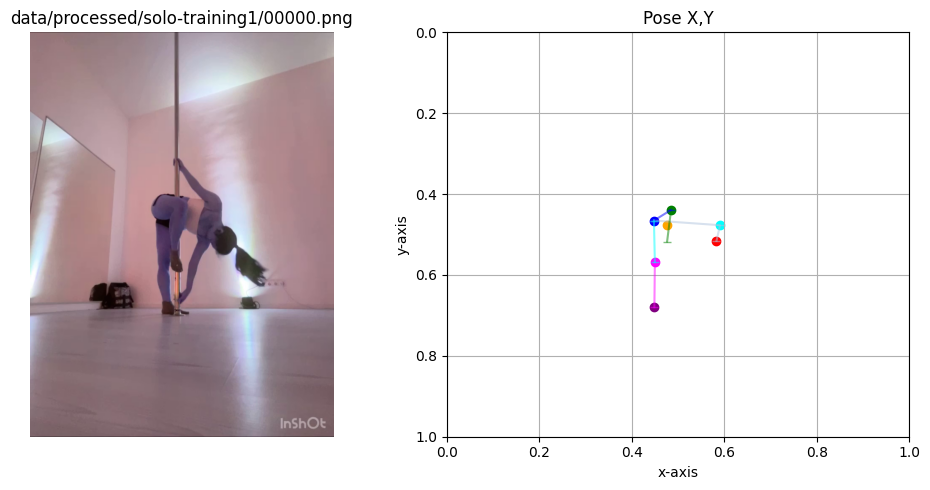

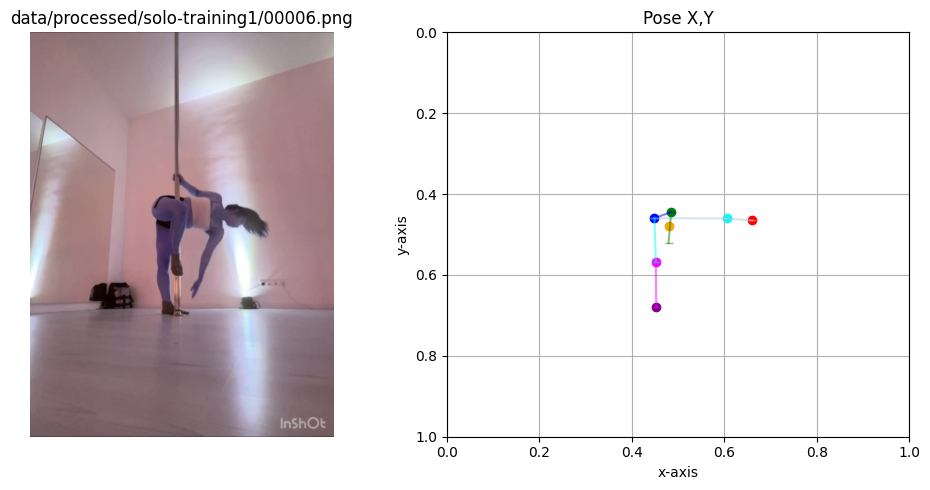

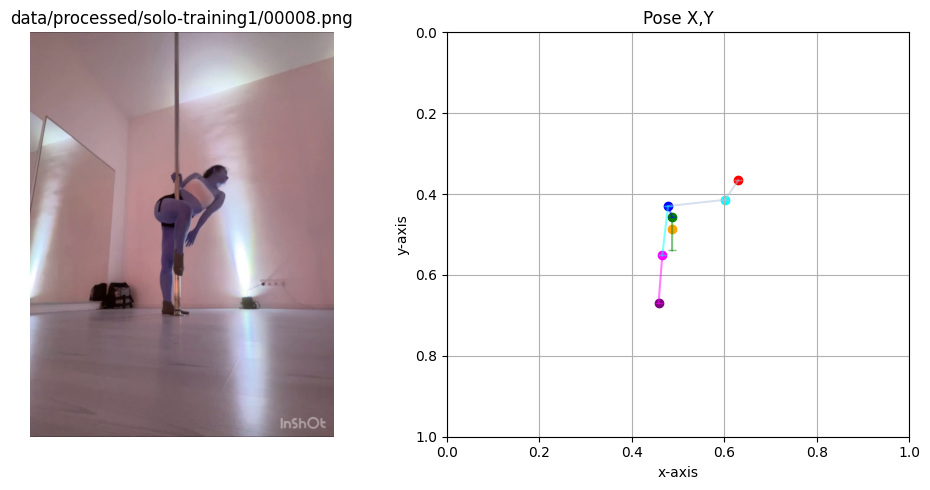

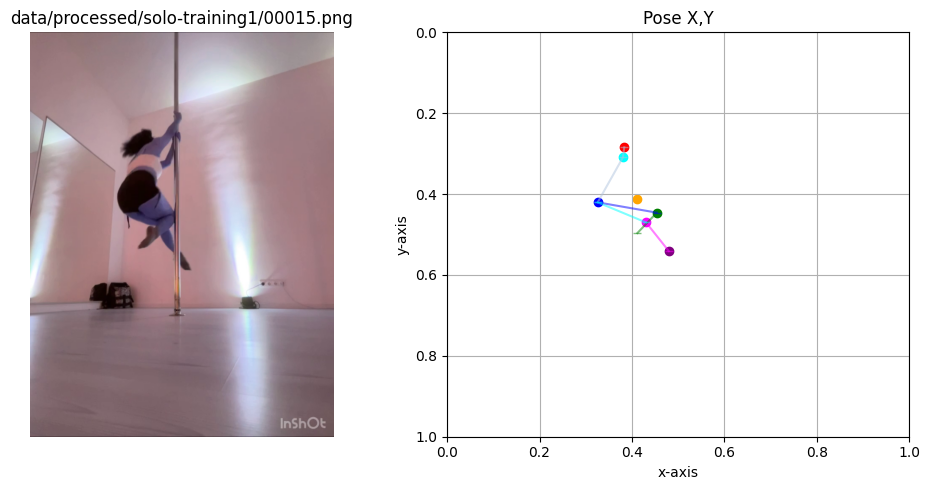

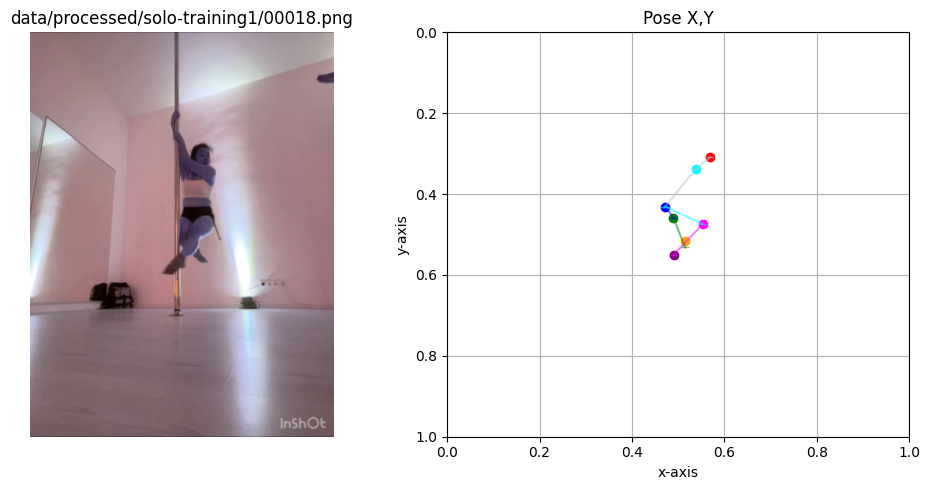

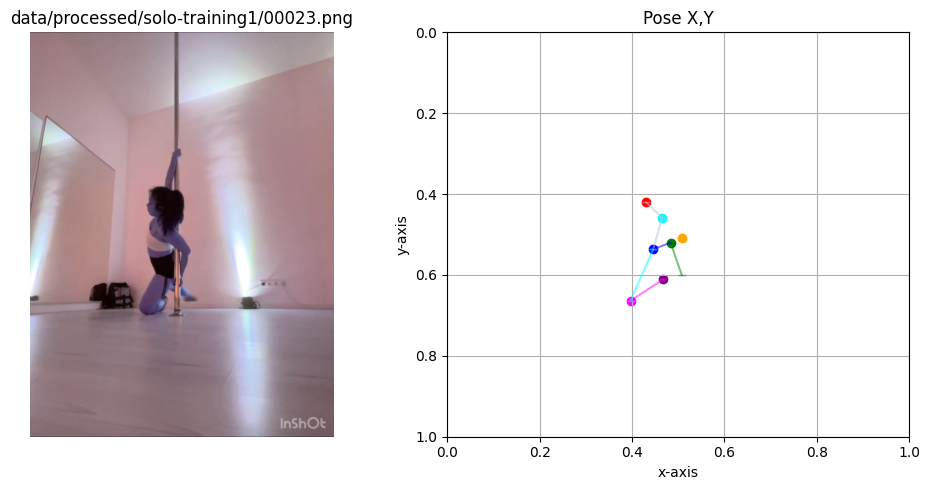

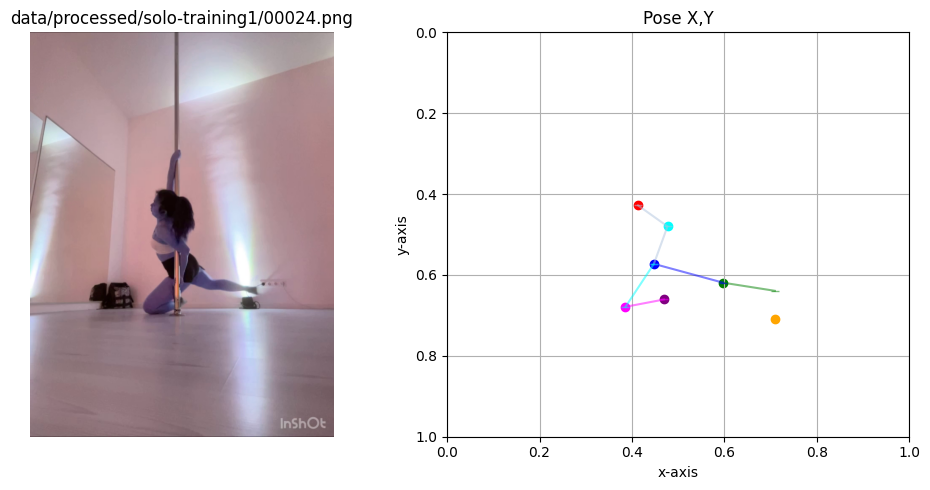

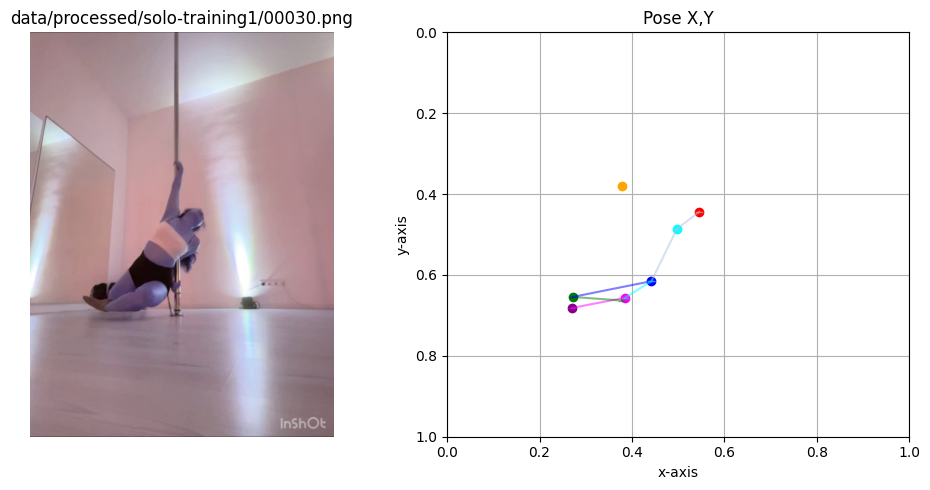

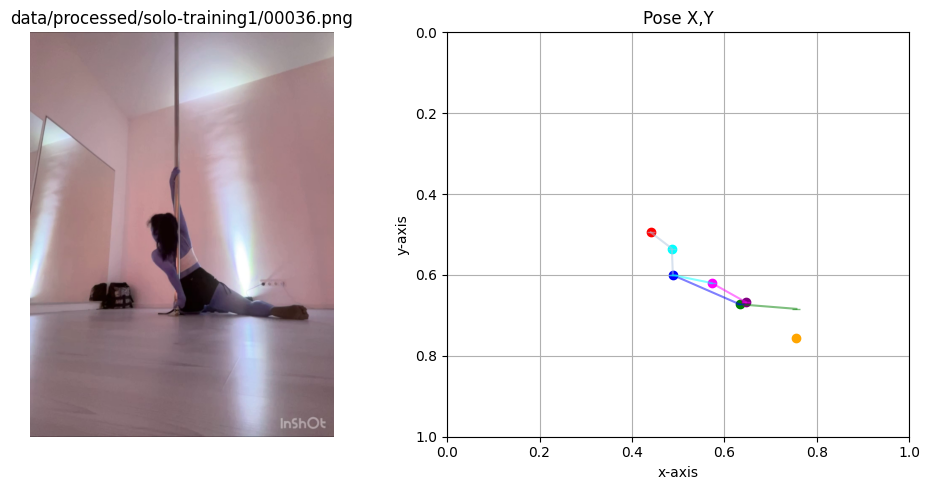

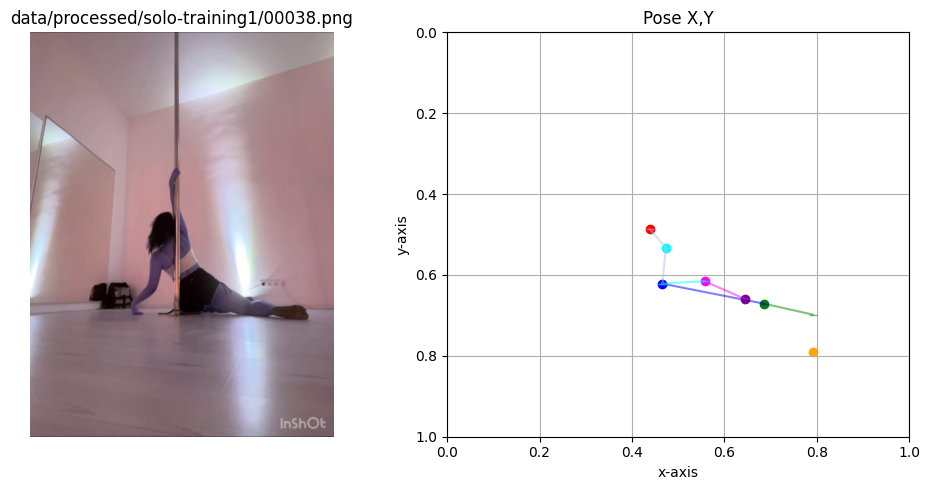

In [54]:
for i in range(10):
    plot_pose_dictionary_entry(user_df,i)

## References

* https://github.com/google/mediapipe